In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd

In [2]:
import os
if not os.path.exists('Results'):
   os.makedirs('Results')
if not os.path.exists('Models'):
   os.makedirs('Models')

In [3]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64 
FEATURES_GEN = 64 
NUM_CLASSES = 10
EMBED_SIZE = 100
criticItr = 5

Device: cuda


In [4]:
dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


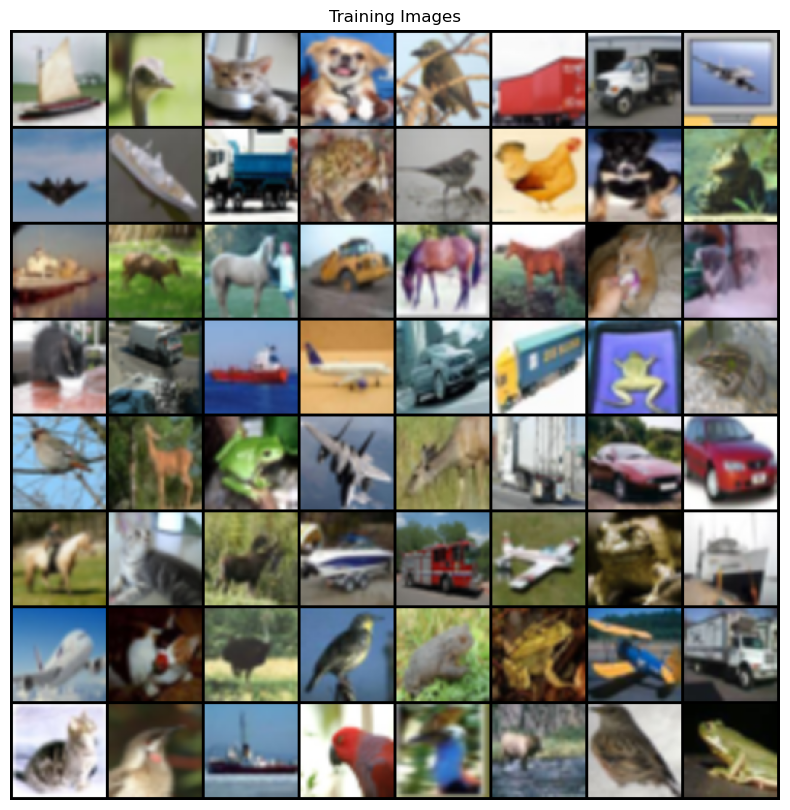

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:BATCH_SIZE], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
class Generator(nn.Module):
    def __init__(self, num_classes, img_size,embed_size,channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            nn.ConvTranspose2d(NOISE_DIM+embed_size,features_g* 16, 4, 1, 0, bias = False),   
#             self.Gnet(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )
        
        self.embed = nn.Embedding(num_classes, embed_size)

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size,channels_img, features_d):    
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self.Dnet(features_d, features_d * 2, 4, 2, 1),      #out=128,k=5,s=2,p=1
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  #out=256,k=5,s=2,p=1
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  #out=512,k=5,s=2,p=1
        )
        self.validity_layer = nn.Sequential(
            nn.Conv2d(512,1,4,1,0,bias = False),
                               nn.Sigmoid())
        
        self.labels = nn.Sequential(
            nn.Conv2d(512, 11, 4, 1, 0, bias = False), 
            nn.LogSoftmax(dim = 1)
                                        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)
        
        

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            #nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    


    def forward(self, x):
        x = self.disc(x)
        valid = self.validity_layer(x).view(-1)
        label = self.labels(x).view(-1,11)
        return valid,label



In [7]:
def weights_initialization(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

gen = Generator(NUM_CLASSES, IMAGE_SIZE,EMBED_SIZE,NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(NUM_CLASSES, IMAGE_SIZE,CHANNELS_IMG, FEATURES_DISC).to(device)
weights_initialization(gen)
weights_initialization(disc)



In [8]:


gen.train() , disc.train()



(Generator(
   (net): Sequential(
     (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (5): Tanh()
   )
   (embed): Embedding(10, 100)
 ),
 Discriminato

In [9]:
class PretrainedInceptionV3(nn.Module):
    """Pretrained PretrainedInceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(PretrainedInceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = PretrainedInceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = PretrainedInceptionV3([block_idx])
model=model.cuda()

def compute_activation_metrics(images,model,batch_size=128, feature_dim=2048,
                    cuda=False):
    model.eval()
    activations=np.empty((len(images), feature_dim))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    activations= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mean_vector = np.mean(activations, axis=0)
    cov_matrix = np.cov(activations, rowvar=False)
    return mean_vector, cov_matrix

def compute_frechet_score(mean_1, cov_1, mean_2, cov_2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mean_vector_real, C_1)
    and X_2 ~ N(mean_vector_fake, C_2) is
            d^2 = ||mean_vector_real - mean_vector_fake||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mean_1 = np.atleast_1d(mean_1)
    mean_2 = np.atleast_1d(mean_2)

    cov_1 = np.atleast_2d(cov_1)
    cov_2 = np.atleast_2d(cov_2)

    assert mean_1.shape == mean_2.shape, \
        'Training and test mean vectors have different lengths'
    assert cov_1.shape == cov_2.shape, \
        'Training and test covariances have different dimensions'

    diff = mean_1 - mean_2

    
    sqrt_cov_product, _ = linalg.sqrtm(cov_1.dot(cov_2), disp=False)
    if not np.isfinite(sqrt_cov_product).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(cov_1.shape[0]) * eps
        sqrt_cov_product = linalg.sqrtm((cov_1 + offset).dot(cov_2 + offset))

    
    if np.iscomplexobj(sqrt_cov_product):
        if not np.allclose(np.diagonal(sqrt_cov_product).imag, 0, atol=1e-3):
            m = np.max(np.abs(sqrt_cov_product.imag))
            raise ValueError('Imaginary component {}'.format(m))
        sqrt_cov_product = sqrt_cov_product.real

    trace_sqrt_cov = np.trace(sqrt_cov_product)

    return (diff.dot(diff) + np.trace(cov_1) +
            np.trace(cov_2) - 2 * trace_sqrt_cov)

def compute_fid_score(real_images,generated_images,model):
    mean_vector_real,std_1=compute_activation_metrics(real_images,model,cuda=True)
    mean_vector_fake,std_2=compute_activation_metrics(generated_images,model,cuda=True)
    
    """get fretched distance"""
    fid_result = compute_frechet_score(mean_vector_real, std_1, mean_vector_fake, std_2)
    return fid_result

/home/tvaspar/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tvaspar/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
step = 0

In [11]:
disc_optimizer = optim.Adam(disc.parameters(),LEARNING_RATE, betas = (0.5,0.999))
gen_optimizer = optim.Adam(gen.parameters(), LEARNING_RATE, betas = (0.5,0.999))
loss_function = nn.BCELoss()
epoch_counters = []
epoch_counter = 0
gen_loss_history = []
disc_loss_history = []
generated_images_list = []

In [12]:
generator_loss_history = []
discriminator_loss_history = []
generated_images_list = []
iteration_count = 0
fid_scores = []

print("Training Started")
# start timing
time_start = time.time() 
for epoch in range(NUM_EPOCHS):
    epoch = epoch+1
    
#     for batch_idx, (real, _) in enumerate(dataloader):

    for batch_idx, (realImg,labels) in enumerate(dataloader):
        #training with real batch
        real = realImg.to(device)
        labels = labels.to(device)
        miniBatch = real.shape[0]
        #print(miniBatch)
        fakeClassLabel =  10*torch.ones((miniBatch,),dtype = torch.long).to(device)        
        disc.zero_grad()
        
        ##########################
        ### Train Discriminator###
        ##########################
        
        ### Train Discriminator with Real image####
        real_labels =  torch.full((miniBatch,), 1.0, dtype=torch.float).to(device)
        discriminator_real_output, discriminator_real_label = disc(real)
        loss_disc_realVal = loss_function(discriminator_real_output, real_labels)
        discRealLabelLoss = F.nll_loss(discriminator_real_label, labels) 
        realLoss_disc = loss_disc_realVal + discRealLabelLoss
        realLoss_disc.backward()
        
        ### Train Discriminator with Fake image####
        random_labels = torch.randint(0, 10, (miniBatch,), dtype = torch.long).to(device)
        noise = torch.randn(miniBatch, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise,random_labels) #genrator img data
        discriminator_fake_output, discriminator_fake_label = disc(fake.detach())
        real_labels.fill_(0.0)
        loss_disc_fakelVal = loss_function(discriminator_fake_output, real_labels)
        discFakeLabelLoss = F.nll_loss(discriminator_fake_label, fakeClassLabel) 
        fakeLoss_disc = loss_disc_fakelVal + discFakeLabelLoss
        fakeLoss_disc.backward()
        #avg disc Loss
        loss_disc = (realLoss_disc+fakeLoss_disc)/2
        disc_optimizer.step()
        
        #######################
        ### Train Generator ###
        #######################
        gen.zero_grad()
        noise = torch.randn(miniBatch, NOISE_DIM, 1, 1).to(device)
        random_labels = torch.randint(0,10,(miniBatch,),dtype = torch.long).to(device)
        real_labels.fill_(1.0)
        fake = gen(noise, random_labels)
        genOutput, genOutputLabel = disc(fake)
        #Loss#
        loss_gen_r = loss_function(genOutput, real_labels)
        genLabelLoss = F.nll_loss(genOutputLabel, random_labels)
        loss_gen = loss_gen_r + genLabelLoss
        loss_gen.backward()
        gen_optimizer.step()
        #saving the losses for every 100 batch
        generator_loss_history.append(loss_gen.detach().cpu())
        discriminator_loss_history.append(loss_disc.detach().cpu())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iteration_count % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(noise,random_labels).detach().cpu()
            generated_images_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iteration_count += 1
        
    #Cal. FID
    fretchet_dist=compute_fid_score(real,fake,model)
    fid_scores.append(fretchet_dist)
    if epoch % 5  == 0:
               print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
        Loss Discriminator: {loss_disc:.3f}, loss Generator: {loss_gen:.3f}, FID Score: {fretchet_dist:.3f} ") 
    
    
    #Saving Generated image/epoch
    if not os.path.exists('Results/ACGAN_FAKE'):
       os.makedirs('Results/ACGAN_FAKE')
    if not os.path.exists('Results/ACGAN_REAL'):
       os.makedirs('Results/ACGAN_REAL')
    images = gen(noise,random_labels).detach()
    utils.save_image(images.detach(),'Results/ACGAN_FAKE/ACGAN_epoch_%03d.png' % (epoch), normalize = True)
    
    #Saving Real image/epoch 
    utils.save_image(real.detach(),'Results/ACGAN_REAL/ACGAN_epoch_%03d.png' % (epoch), normalize = True)
        
    
time_end = time.time()
print('\n\n elapsed time：%.2f s.'%(time_end-time_start))

Training Started
Epoch [5/40] Batch 781/782         Loss Discriminator: 2.140, loss Generator: 2.364, FID Score: 424.046 
Epoch [10/40] Batch 781/782         Loss Discriminator: 1.842, loss Generator: 3.147, FID Score: 371.719 
Epoch [15/40] Batch 781/782         Loss Discriminator: 1.709, loss Generator: 4.503, FID Score: 343.921 
Epoch [20/40] Batch 781/782         Loss Discriminator: 1.583, loss Generator: 4.799, FID Score: 297.807 
Epoch [25/40] Batch 781/782         Loss Discriminator: 1.680, loss Generator: 3.093, FID Score: 296.028 
Epoch [30/40] Batch 781/782         Loss Discriminator: 1.130, loss Generator: 4.078, FID Score: 296.778 
Epoch [35/40] Batch 781/782         Loss Discriminator: 1.476, loss Generator: 2.530, FID Score: 299.411 
Epoch [40/40] Batch 781/782         Loss Discriminator: 1.386, loss Generator: 3.125, FID Score: 323.419 


 elapsed time：801.91 s.


In [13]:
if not os.path.exists('Results/Loss_Data'):
       os.makedirs('Results/Loss_Data')
np.save('Results/Loss_Data/ACGAN_GLoss', generator_loss_history) 
np.save('Results/Loss_Data/ACGAN_DLoss', discriminator_loss_history) 

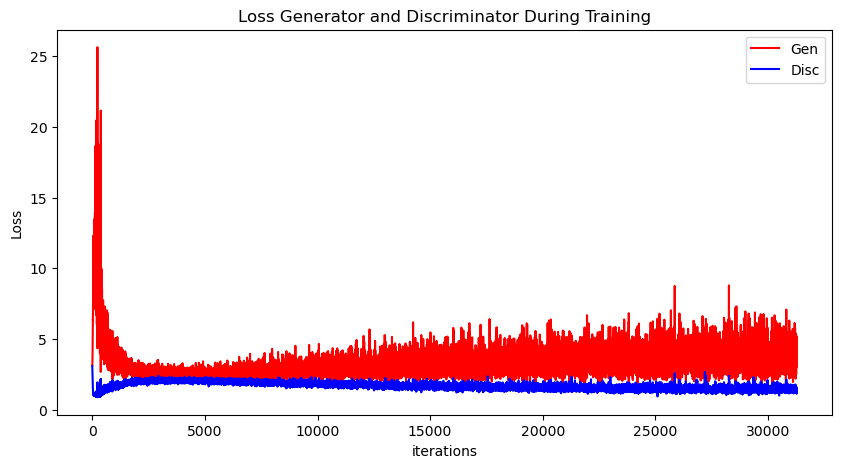

In [14]:
generator_loss_history = np.load('Results/Loss_Data/ACGAN_GLoss.npy')
discriminator_loss_history = np.load('Results/Loss_Data/ACGAN_DLoss.npy')

plt.figure(figsize=(10,5))
plt.title("Loss Generator and Discriminator During Training")
plt.plot(generator_loss_history,label="Gen", color="red")
plt.plot(discriminator_loss_history,label="Disc", color="blue")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Results/LOSS_AC.pdf',
            format='pdf',
            dpi=100,
            bbox_inches='tight')
plt.show()



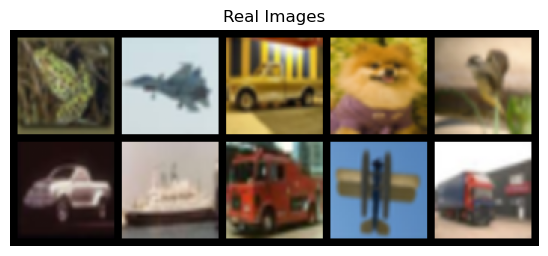

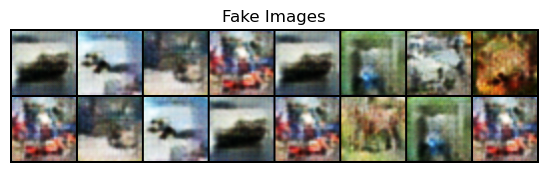

In [15]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10], nrow=5, padding=5, normalize=True).cpu(), (1, 2, 0)))

# Plot the fake images from the last epoch
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(generated_images_list[-1], (1, 2, 0)))

# Save the resulting figure
plt.savefig('Results/ACGAN_BEST_FAKE_32.pdf',
            format='pdf',
            dpi=100,
            bbox_inches='tight')
plt.show()


In [16]:


len(generated_images_list)



64

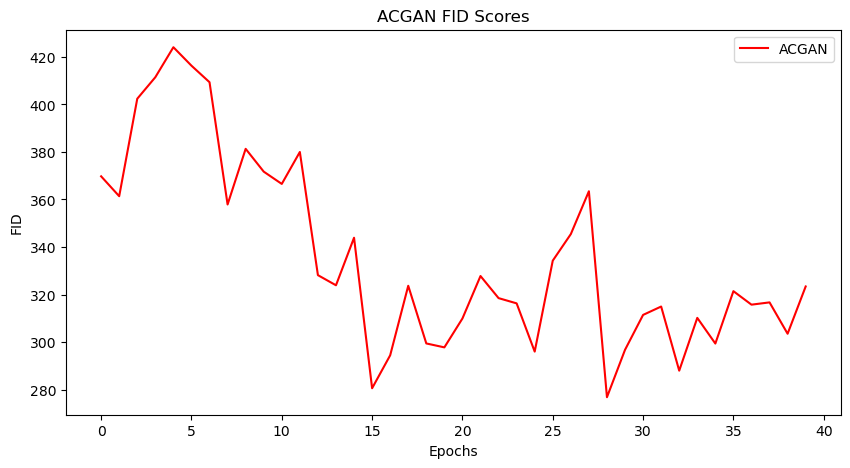

In [17]:
plt.figure(figsize=(10,5))
plt.title("ACGAN FID Scores")
plt.plot(fid_scores,label="ACGAN", color="red")
# plt.plot(W_FIDScore,label="WGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('Results/FID.pdf',
            format='pdf',
            bbox_inches='tight')
plt.show()

In [18]:
if not os.path.exists('Results/FID_score'):
       os.makedirs('Results/FID_score')
np.save('Results/FID_score/ACGAN_FID', fid_scores) 

In [19]:
np.min(fid_scores), np.max(fid_scores), np.mean(fid_scores), fid_scores[-5]

(276.83911152400196, 424.0459308020485, 335.8638028504793, 321.44411283781443)

In [20]:
np.mean(generator_loss_history),np.mean(discriminator_loss_history),np.min(generator_loss_history),np.min(discriminator_loss_history),generator_loss_history[-1],discriminator_loss_history[-1]

(3.311155, 1.6779206, 1.5799968, 0.8844293, 3.125185, 1.3862973)